In [ ]:
# This file runs the Detectron2 Faster R-CNN model on a custom dataset 
# This is based on the Detectron2 beginner tutorial from here:
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=ZyAvNCJMmvFF

# Also,checkout here: https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-output-format%20for%20specification

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
print(torchvision.__version__)
!gcc --version

1.7.1 True
0.8.2
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
from platform import python_version
print(python_version())

3.8.5


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

print("done")

done


In [5]:
import cv2
print(cv2.__version__)

4.5.1


In [6]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.data.datasets import register_coco_instances
register_coco_instances("DoorDetectVer1_train", {}, "/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json", "/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train")
register_coco_instances("DoorDetectVer1_test", {}, "/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test.json", "/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test")
DoorDetectVer1_metadata = MetadataCatalog.get("DoorDetectVer1_train")

In [7]:
print(DoorDetectVer1_metadata)

Metadata(evaluator_type='coco', image_root='/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train', json_file='/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json', name='DoorDetectVer1_train')


In [8]:
dataset_dicts_train = DatasetCatalog.get("DoorDetectVer1_train")
print(DoorDetectVer1_metadata)

[04/01 22:23:07 d2.data.datasets.coco]: Loaded 972 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json
Metadata(evaluator_type='coco', image_root='/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train', json_file='/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json', name='DoorDetectVer1_train', thing_classes=['door', 'handle', 'cabinet door', 'refrigerator door'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3})


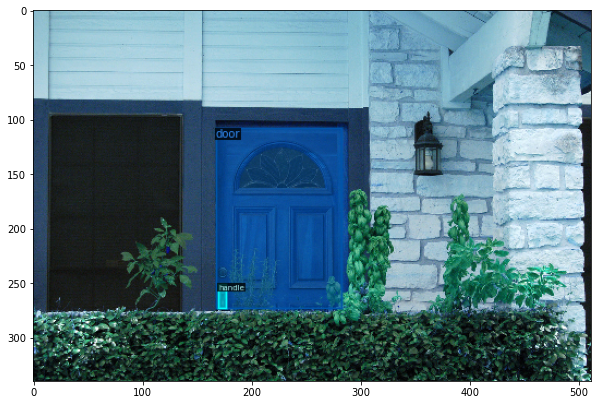

In [18]:
for d in random.sample(dataset_dicts_train, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=DoorDetectVer1_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    #cv2_imshow(vis.get_image()[:,:,::-1])
    plt.figure(figsize=(10,10))
    imgplot = plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    

## Faster R-CNN

In [106]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("DoorDetectVer1_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # original was 0.00025 pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512) previous was 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/03 22:43:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[04/03 22:43:33 d2.data.datasets.coco]: Loaded 972 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json
[04/03 22:43:33 d2.data.build]: Removed 0 images with no usable annotations. 972 images left.
[04/03 22:43:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/03 22:43:34 d2.data.build]: Using training sampler TrainingSampler
[04/03 22:43:34 d2.data.common]: Serializing 972 elements to byte tensors and concatenating them all ...
[04/03 22:43:34 d2.data.common]: Serialized dataset takes 1.06 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[04/03 22:43:34 d2.engine.train_loop]: Starting training from iteration 0
[04/03 22:43:40 d2.utils.events]:  eta: 0:25:38  iter: 19  total_loss: 2.551  loss_cls: 1.773  loss_box_reg: 0.1039  loss_rpn_cls: 0.5186  loss_rpn_loc: 0.06597  time: 0.3162  data_time: 0.0070  lr: 4.9953e-06  max_mem: 4767M
[04/03 22:43:47 d2.utils.events]:  eta: 0:25:49  iter: 39  total_loss: 2.576  loss_cls: 1.673  loss_box_reg: 0.1165  loss_rpn_cls: 0.7223  loss_rpn_loc: 0.113  time: 0.3211  data_time: 0.0028  lr: 9.9902e-06  max_mem: 4767M
[04/03 22:43:53 d2.utils.events]:  eta: 0:25:29  iter: 59  total_loss: 2.096  loss_cls: 1.431  loss_box_reg: 0.1355  loss_rpn_cls: 0.4595  loss_rpn_loc: 0.08993  time: 0.3178  data_time: 0.0025  lr: 1.4985e-05  max_mem: 4780M
[04/03 22:43:59 d2.utils.events]:  eta: 0:25:16  iter: 79  total_loss: 1.786  loss_cls: 1.135  loss_box_reg: 0.09513  loss_rpn_cls: 0.4061  loss_rpn_loc: 0.1087  time: 0.3136  data_time: 0.0038  lr: 1.998e-05  max_mem: 4780M
[04/03 22:44:05 d2.utils.

[04/03 22:47:24 d2.utils.events]:  eta: 0:22:18  iter: 719  total_loss: 0.8194  loss_cls: 0.24  loss_box_reg: 0.2977  loss_rpn_cls: 0.06296  loss_rpn_loc: 0.06412  time: 0.3193  data_time: 0.0025  lr: 0.00017982  max_mem: 4780M
[04/03 22:47:30 d2.utils.events]:  eta: 0:22:10  iter: 739  total_loss: 0.9783  loss_cls: 0.3441  loss_box_reg: 0.4388  loss_rpn_cls: 0.06145  loss_rpn_loc: 0.1028  time: 0.3190  data_time: 0.0044  lr: 0.00018482  max_mem: 4780M
[04/03 22:47:37 d2.utils.events]:  eta: 0:22:03  iter: 759  total_loss: 0.8021  loss_cls: 0.2465  loss_box_reg: 0.3157  loss_rpn_cls: 0.05646  loss_rpn_loc: 0.09219  time: 0.3190  data_time: 0.0025  lr: 0.00018981  max_mem: 4780M
[04/03 22:47:43 d2.utils.events]:  eta: 0:21:56  iter: 779  total_loss: 0.7172  loss_cls: 0.266  loss_box_reg: 0.3451  loss_rpn_cls: 0.05519  loss_rpn_loc: 0.07558  time: 0.3189  data_time: 0.0025  lr: 0.00019481  max_mem: 4780M
[04/03 22:47:49 d2.utils.events]:  eta: 0:21:49  iter: 799  total_loss: 0.7914  loss

[04/03 22:51:07 d2.utils.events]:  eta: 0:18:38  iter: 1419  total_loss: 0.6828  loss_cls: 0.2286  loss_box_reg: 0.3336  loss_rpn_cls: 0.03701  loss_rpn_loc: 0.06874  time: 0.3187  data_time: 0.0029  lr: 0.00025  max_mem: 4780M
[04/03 22:51:13 d2.utils.events]:  eta: 0:18:32  iter: 1439  total_loss: 0.6196  loss_cls: 0.2454  loss_box_reg: 0.2918  loss_rpn_cls: 0.04331  loss_rpn_loc: 0.07634  time: 0.3186  data_time: 0.0027  lr: 0.00025  max_mem: 4780M
[04/03 22:51:20 d2.utils.events]:  eta: 0:18:25  iter: 1459  total_loss: 0.6877  loss_cls: 0.2597  loss_box_reg: 0.2975  loss_rpn_cls: 0.05737  loss_rpn_loc: 0.09418  time: 0.3186  data_time: 0.0024  lr: 0.00025  max_mem: 4780M
[04/03 22:51:26 d2.utils.events]:  eta: 0:18:20  iter: 1479  total_loss: 0.8245  loss_cls: 0.2813  loss_box_reg: 0.4219  loss_rpn_cls: 0.04769  loss_rpn_loc: 0.09041  time: 0.3185  data_time: 0.0027  lr: 0.00025  max_mem: 4780M
[04/03 22:51:32 d2.utils.events]:  eta: 0:18:14  iter: 1499  total_loss: 0.7283  loss_cl

[04/03 22:54:51 d2.utils.events]:  eta: 0:14:58  iter: 2119  total_loss: 0.6161  loss_cls: 0.2407  loss_box_reg: 0.2607  loss_rpn_cls: 0.03243  loss_rpn_loc: 0.06806  time: 0.3188  data_time: 0.0023  lr: 0.00025  max_mem: 4780M
[04/03 22:54:57 d2.utils.events]:  eta: 0:14:52  iter: 2139  total_loss: 0.6749  loss_cls: 0.2486  loss_box_reg: 0.2988  loss_rpn_cls: 0.03956  loss_rpn_loc: 0.07456  time: 0.3189  data_time: 0.0025  lr: 0.00025  max_mem: 4780M
[04/03 22:55:04 d2.utils.events]:  eta: 0:14:45  iter: 2159  total_loss: 0.6687  loss_cls: 0.228  loss_box_reg: 0.2896  loss_rpn_cls: 0.0404  loss_rpn_loc: 0.0817  time: 0.3190  data_time: 0.0026  lr: 0.00025  max_mem: 4780M
[04/03 22:55:10 d2.utils.events]:  eta: 0:14:40  iter: 2179  total_loss: 0.6669  loss_cls: 0.2035  loss_box_reg: 0.2363  loss_rpn_cls: 0.03432  loss_rpn_loc: 0.07809  time: 0.3189  data_time: 0.0027  lr: 0.00025  max_mem: 4780M
[04/03 22:55:16 d2.utils.events]:  eta: 0:14:33  iter: 2199  total_loss: 0.5818  loss_cls: 

[04/03 22:58:33 d2.utils.events]:  eta: 0:11:18  iter: 2819  total_loss: 0.478  loss_cls: 0.1795  loss_box_reg: 0.2548  loss_rpn_cls: 0.01806  loss_rpn_loc: 0.05294  time: 0.3185  data_time: 0.0029  lr: 0.00025  max_mem: 4780M
[04/03 22:58:39 d2.utils.events]:  eta: 0:11:12  iter: 2839  total_loss: 0.5501  loss_cls: 0.1848  loss_box_reg: 0.303  loss_rpn_cls: 0.02262  loss_rpn_loc: 0.05366  time: 0.3184  data_time: 0.0026  lr: 0.00025  max_mem: 4780M
[04/03 22:58:46 d2.utils.events]:  eta: 0:11:06  iter: 2859  total_loss: 0.6741  loss_cls: 0.2211  loss_box_reg: 0.3339  loss_rpn_cls: 0.02727  loss_rpn_loc: 0.09538  time: 0.3185  data_time: 0.0026  lr: 0.00025  max_mem: 4780M
[04/03 22:58:52 d2.utils.events]:  eta: 0:11:00  iter: 2879  total_loss: 0.6292  loss_cls: 0.2227  loss_box_reg: 0.2486  loss_rpn_cls: 0.03795  loss_rpn_loc: 0.03515  time: 0.3184  data_time: 0.0025  lr: 0.00025  max_mem: 4780M
[04/03 22:58:58 d2.utils.events]:  eta: 0:10:53  iter: 2899  total_loss: 0.533  loss_cls: 

[04/03 23:02:17 d2.utils.events]:  eta: 0:07:41  iter: 3519  total_loss: 0.5312  loss_cls: 0.1814  loss_box_reg: 0.2821  loss_rpn_cls: 0.02134  loss_rpn_loc: 0.07863  time: 0.3187  data_time: 0.0089  lr: 0.00025  max_mem: 4780M
[04/03 23:02:23 d2.utils.events]:  eta: 0:07:35  iter: 3539  total_loss: 0.5764  loss_cls: 0.2071  loss_box_reg: 0.2916  loss_rpn_cls: 0.02529  loss_rpn_loc: 0.05747  time: 0.3186  data_time: 0.0026  lr: 0.00025  max_mem: 4780M
[04/03 23:02:30 d2.utils.events]:  eta: 0:07:29  iter: 3559  total_loss: 0.6143  loss_cls: 0.2012  loss_box_reg: 0.3145  loss_rpn_cls: 0.02654  loss_rpn_loc: 0.07678  time: 0.3187  data_time: 0.0028  lr: 0.00025  max_mem: 4780M
[04/03 23:02:36 d2.utils.events]:  eta: 0:07:22  iter: 3579  total_loss: 0.6011  loss_cls: 0.1886  loss_box_reg: 0.2797  loss_rpn_cls: 0.0231  loss_rpn_loc: 0.05528  time: 0.3186  data_time: 0.0027  lr: 0.00025  max_mem: 4780M
[04/03 23:02:42 d2.utils.events]:  eta: 0:07:16  iter: 3599  total_loss: 0.562  loss_cls:

[04/03 23:06:01 d2.utils.events]:  eta: 0:04:04  iter: 4219  total_loss: 0.7358  loss_cls: 0.2234  loss_box_reg: 0.3566  loss_rpn_cls: 0.02784  loss_rpn_loc: 0.09887  time: 0.3187  data_time: 0.0027  lr: 0.00025  max_mem: 4780M
[04/03 23:06:07 d2.utils.events]:  eta: 0:03:58  iter: 4239  total_loss: 0.546  loss_cls: 0.1879  loss_box_reg: 0.2999  loss_rpn_cls: 0.02339  loss_rpn_loc: 0.06223  time: 0.3187  data_time: 0.0024  lr: 0.00025  max_mem: 4780M
[04/03 23:06:14 d2.utils.events]:  eta: 0:03:51  iter: 4259  total_loss: 0.4793  loss_cls: 0.171  loss_box_reg: 0.2037  loss_rpn_cls: 0.02649  loss_rpn_loc: 0.05263  time: 0.3188  data_time: 0.0026  lr: 0.00025  max_mem: 4780M
[04/03 23:06:20 d2.utils.events]:  eta: 0:03:45  iter: 4279  total_loss: 0.5807  loss_cls: 0.2079  loss_box_reg: 0.2969  loss_rpn_cls: 0.02197  loss_rpn_loc: 0.05746  time: 0.3189  data_time: 0.0061  lr: 0.00025  max_mem: 4780M
[04/03 23:06:27 d2.utils.events]:  eta: 0:03:39  iter: 4299  total_loss: 0.5852  loss_cls:

[04/03 23:09:52 d2.utils.events]:  eta: 0:00:25  iter: 4919  total_loss: 0.4692  loss_cls: 0.1659  loss_box_reg: 0.2401  loss_rpn_cls: 0.01192  loss_rpn_loc: 0.0431  time: 0.3204  data_time: 0.0025  lr: 0.00025  max_mem: 4780M
[04/03 23:09:59 d2.utils.events]:  eta: 0:00:19  iter: 4939  total_loss: 0.3682  loss_cls: 0.1067  loss_box_reg: 0.1809  loss_rpn_cls: 0.01162  loss_rpn_loc: 0.02721  time: 0.3204  data_time: 0.0027  lr: 0.00025  max_mem: 4780M
[04/03 23:10:05 d2.utils.events]:  eta: 0:00:12  iter: 4959  total_loss: 0.5159  loss_cls: 0.1435  loss_box_reg: 0.2497  loss_rpn_cls: 0.02228  loss_rpn_loc: 0.06973  time: 0.3204  data_time: 0.0024  lr: 0.00025  max_mem: 4780M
[04/03 23:10:12 d2.utils.events]:  eta: 0:00:06  iter: 4979  total_loss: 0.4345  loss_cls: 0.1551  loss_box_reg: 0.2115  loss_rpn_cls: 0.02149  loss_rpn_loc: 0.04231  time: 0.3204  data_time: 0.0025  lr: 0.00025  max_mem: 4780M
[04/03 23:10:20 d2.utils.events]:  eta: 0:00:00  iter: 4999  total_loss: 0.6109  loss_cls

In [107]:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 51604), started 1 day, 13:35:03 ago. (Use '!kill 51604' to kill it.)

In [108]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/03 23:32:26 d2.data.datasets.coco]: Loaded 120 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test.json


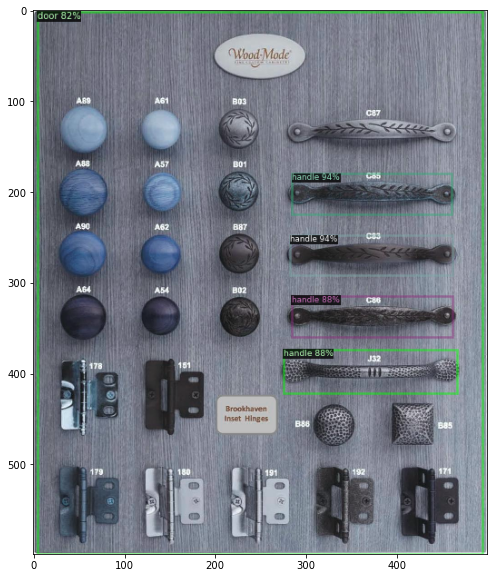

In [110]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_test = DatasetCatalog.get("DoorDetectVer1_test")
for d in random.sample(dataset_dicts_test, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata= DoorDetectVer1_metadata, 
                   scale=0.5, 
                     # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,10))
    imgplot = plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    

In [111]:
print(d["file_name"])

/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test/Wood_Mode_Brookhaven_Hardware_Kitchen_Associates-1.jpg


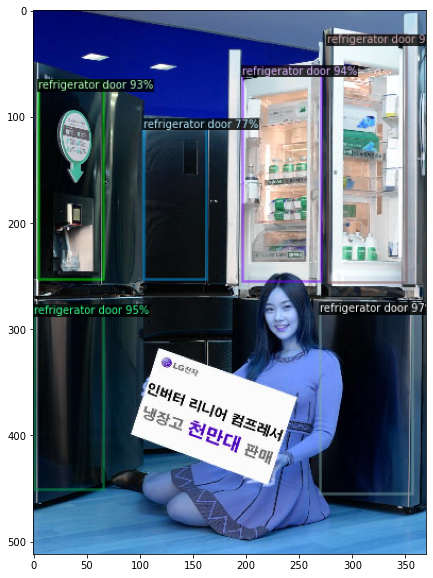

In [113]:
im = cv2.imread("/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test/2e193eef6f6a4561.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                   metadata= DoorDetectVer1_metadata, 
                   scale=0.5, 
                     # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(10,10))
imgplot = plt.imshow(out.get_image()[:, :, ::-1])
plt.show()
    

In [114]:
print(outputs)

{'instances': Instances(num_instances=6, image_height=1024, image_width=741, fields=[pred_boxes: Boxes(tensor([[539.5370, 552.4073, 714.5799, 909.2004],
        [553.9537,  46.7055, 701.9584, 512.6761],
        [  2.7230, 555.6169, 131.0402, 901.1054],
        [393.1878, 105.5315, 542.0081, 510.4546],
        [ 10.3958, 131.9634, 132.3162, 506.4061],
        [207.6815, 205.1812, 325.7771, 506.0284]], device='cuda:0')), scores: tensor([0.9673, 0.9584, 0.9499, 0.9379, 0.9328, 0.7720], device='cuda:0'), pred_classes: tensor([3, 3, 3, 3, 3, 3], device='cuda:0')])}


In [115]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("DoorDetectVer1_test", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "DoorDetectVer1_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[04/03 23:32:49 d2.data.datasets.coco]: Loaded 120 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test.json
[04/03 23:32:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/03 23:32:49 d2.data.common]: Serializing 120 elements to byte tensors and concatenating them all ...
[04/03 23:32:49 d2.data.common]: Serialized dataset takes 0.12 MiB
[04/03 23:32:49 d2.evaluation.evaluator]: Start inference on 120 images
[04/03 23:32:50 d2.evaluation.evaluator]: Inference done 11/120. 0.0741 s / img. ETA=0:00:08
[04/03 23:32:55 d2.evaluation.evaluator]: Inference done 72/120. 0.0743 s / img. ETA=0:00:03
[04/03 23:32:59 d2.evaluation.evaluator]: Total inference time: 0:00:09.692330 (0.084281 s / img per device, on 1 devices)
[04/03 23:32:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:08 (0.074618 s / img per device, on 1 devic

TypeError: list indices must be integers or slices, not str

# MaskR-CNN

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("DoorDetectVer1_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  #number of classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [137]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7497), started 3:21:21 ago. (Use '!kill 7497' to kill it.)

In [133]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/12 19:21:29 d2.data.datasets.coco]: Loaded 120 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test.json


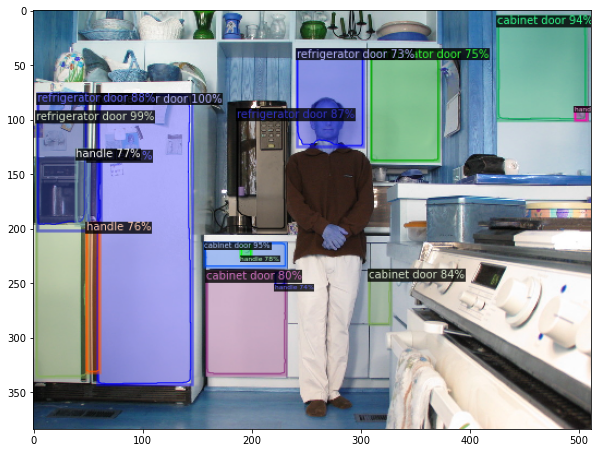

In [134]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_test = DatasetCatalog.get("DoorDetectVer1_test")
for d in random.sample(dataset_dicts_test, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata= DoorDetectVer1_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW# remove the colors of unsegmented pixels. This option is only available for segmentation models
    
                  )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,10))
    imgplot = plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

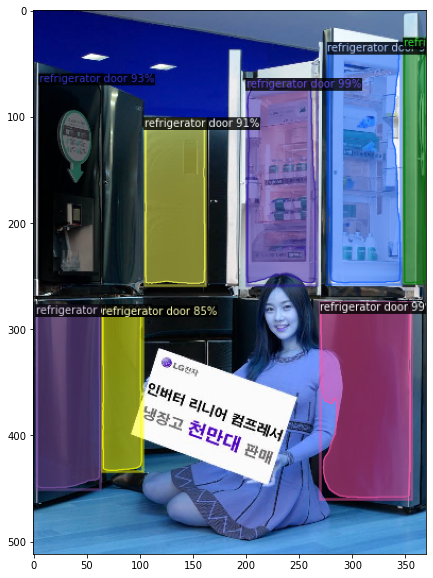

In [135]:
im = cv2.imread("/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test/2e193eef6f6a4561.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                   metadata= DoorDetectVer1_metadata, 
                   scale=0.5, 
                     # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(10,10))
imgplot = plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

In [136]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("DoorDetectVer1_test", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "DoorDetectVer1_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/12 19:22:35 d2.data.datasets.coco]: Loaded 120 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test.json
[03/12 19:22:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/12 19:22:35 d2.data.common]: Serializing 120 elements to byte tensors and concatenating them all ...
[03/12 19:22:35 d2.data.common]: Serialized dataset takes 0.12 MiB
[03/12 19:22:35 d2.evaluation.evaluator]: Start inference on 120 images
[03/12 19:22:36 d2.evaluation.evaluator]: Inference done 11/120. 0.0649 s / img. ETA=0:00:10
[03/12 19:22:41 d2.evaluation.evaluator]: Inference done 50/120. 0.0634 s / img. ETA=0:00:08
[03/12 19:22:46 d2.evaluation.evaluator]: Inference done 94/120. 0.0620 s / img. ETA=0:00:03
[03/12 19:22:49 d2.evaluation.evaluator]: Total inference time: 0:00:13.673551 (0.118900 s / img per device, on 1 devices)
[03/12 19:22:49 d2.evaluation.ev